<a href="https://colab.research.google.com/github/hpink97/ML_notebooks/blob/main/05_image_classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification with Convultional Nerual Networks (CNNs)



1.   Train a CNN on 60k MNIST digits (~99% accuracy)
2.   Use the Kaggle API to extract image data from dogs-vs-cats competition
3.   Train a binary-classification CNN on 2k images from kaggle dogs-vs-cats competition (~70% accuracy)
4. Improve dog-vs-cats classifier by using Data Augmentation to reduce overfitting 



In [5]:
##import libraries

##tf 

import tensorflow 
from tensorflow import keras
from tensorflow.keras import layers


import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

##file related libs
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import image_dataset_from_directory as import_img_dir
from google.colab import files
import os, shutil, pathlib


##hide warnings
tensorflow.get_logger().setLevel('ERROR')

# Model 1 : MNIST CNN with Maxpooling

In [29]:
#import mnist
(train_val_images, train_val_labels), (test_images, test_labels) = mnist.load_data()

In [30]:
print(f" train shape = {train_val_images.shape}")
print(f" test shape = {test_images.shape}")


 train shape = (60000, 28, 28)
 test shape = (10000, 28, 28)


In [31]:
##shuufle train_val img/labels
shuffle = np.random.permutation(train_val_images.shape[0])
train_val_images = train_val_images[shuffle]
train_val_labels = train_val_labels[shuffle]


##split train into train and validate
train_images = train_val_images[0:50000]
train_labels = train_val_labels[0:50000]


validate_images = train_val_images[50000:]
validate_labels = train_val_labels[50000:]

In [32]:
validate_images.shape

(10000, 28, 28)

### Print an example MNIST digit

In [33]:
#### show an example image
n = int(np.random.choice(train_images.shape[0], 1, replace=False)  )
example_digit = train_images[n]
example_digit

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  29, 230, 239,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 128, 254, 238,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 158, 254, 238,   0,   0,   0,   0,   0,   0

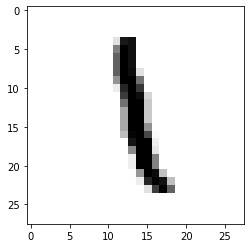

image label =1


In [34]:
plt.imshow(example_digit, cmap=plt.cm.binary)
plt.show()

print(f"image label ={train_labels[n]}")

In [36]:
### reshape and scale data
train_images = train_images.reshape((50000,28,28,1)).astype('float32')/255
validate_images = validate_images.reshape((10000,28,28,1)).astype('float32')/255
test_images = test_images.reshape((10000,28,28,1)).astype('float32')/255

## Initiate the convolutional neural network (CNN)


*   Takes input tensor (image_height, image_width, image_channels)

`Conv2D()` is the convolutional layer. This will split the input tensor into 2D windows of size `kernel_size * kernal_size`. In addition it will also compute `filters`, which is the depth of the layer's output tensor. These are no longer colour channels, but arbritary filters calculated by the layer...


`MaxPooling2D` reduces the size of the output tensor, applying a hardcoded MAX transformation on 2*2 tensors. Allows information to be encoded on a larger proportion of the original input. Also reduces the complexity of the model, reducing compute and overfitting!!.

In [37]:
##initate a CovNet
inputs = keras.Input(shape=(28,28,1)) #28*28 pixel black&white images
my_layers = layers.Conv2D(filters=32, kernel_size=2, activation='relu')(inputs)
my_layers = layers.MaxPooling2D(pool_size =2)(my_layers)
my_layers = layers.Conv2D(filters=128, kernel_size=2, activation='relu')(my_layers)
my_layers = layers.MaxPooling2D(pool_size =2)(my_layers)
my_layers = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(my_layers)
my_layers = layers.MaxPooling2D(pool_size =2)(my_layers)
my_layers = layers.Flatten()(my_layers)
#mnist is 0-9, so output will be shape 10
outputs= layers.Dense(10, activation ='softmax')(my_layers)
mnist_cnn = keras.Model(inputs=inputs, outputs=outputs)

##summarise model
mnist_cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 27, 27, 32)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 128)       16512     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 256)         2951

In [38]:
mnist_cnn.compile(optimizer='rmsprop',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

history = mnist_cnn.fit(train_images,
                        train_labels,
                        epochs=10,
                        batch_size=256,
                        validation_data=(validate_images, validate_labels) )

Epoch 1/10
196/196 [==============================] - 4s 12ms/step - loss: 0.4106 - accuracy: 0.8731 - val_loss: 0.1884 - val_accuracy: 0.9415
Epoch 2/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0885 - accuracy: 0.9721 - val_loss: 0.0873 - val_accuracy: 0.9731
Epoch 3/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0564 - accuracy: 0.9823 - val_loss: 0.0946 - val_accuracy: 0.9705
Epoch 4/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0392 - accuracy: 0.9871 - val_loss: 0.1527 - val_accuracy: 0.9521
Epoch 5/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0303 - accuracy: 0.9904 - val_loss: 0.0880 - val_accuracy: 0.9721
Epoch 6/10
196/196 [==============================] - 2s 11ms/step - loss: 0.0234 - accuracy: 0.9924 - val_loss: 0.0606 - val_accuracy: 0.9823
Epoch 7/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0191 - accuracy: 0.9940 - val_loss: 0.0412 - val_accuracy: 0.9873
E

## Define a function to visualise the training process

In [39]:
def plot_training(hist):
  train_acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']

  train_loss =hist.history['loss']
  val_loss = hist.history['val_loss']

  n_epochs = len(val_loss)+1
  x = range(1,n_epochs)

  ##make accuracy plot
  plt.plot(x , train_acc, 'ro', label = 'Training Accuracy')
  plt.plot(x , val_acc, 'b', label = 'Validation Accuracy')
  plt.title('Training vs Validation Accuracy')
  plt.legend()
  ##make new figure for Loss plot
  plt.figure() 
  plt.plot(x , train_loss, 'ro', label = 'Training Loss')
  plt.plot(x , val_loss, 'b', label = 'Validation Loss')
  plt.title('Training vs Validation Loss')
  plt.legend()
  plt.show()

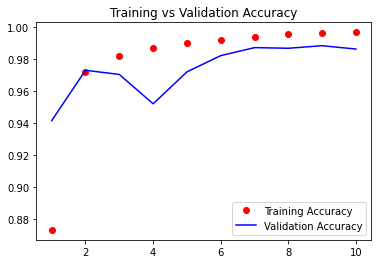

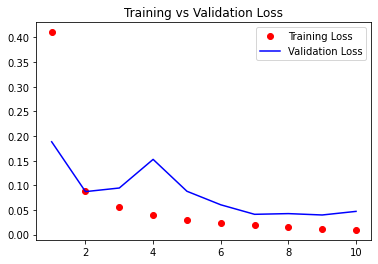

In [41]:
plot_training(history)

## **99% accuracy on the MNIST dataset with this first CNN!!** 🏆 🏆

In [43]:
test_loss, test_acc =mnist_cnn.evaluate(test_images, test_labels, batch_size=256, verbose=0)
print(f"CovNet testing accuracy on MNIST = {test_acc*100:.1f}%")

CovNet testing accuracy on MNIST = 98.8%


# Import `dogs-vs-cats` image dat ausing the Kaggle API






In [3]:
! rm ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle/kaggle.json': No such file or directory


In [6]:
##import cat vs dogs kaggle competetion data


files.upload() ##upload kaggle api key
! mkdir ~/.kaggle/
! cp kaggle.json  ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
##download competition data from API
! kaggle competitions download -c dogs-vs-cats
## unzip files
!unzip -qq dogs-vs-cats.zip
! unzip -qq train.zip

Saving kaggle.json to kaggle.json
 99% 808M/812M [00:04<00:00, 201MB/s]
100% 812M/812M [00:04<00:00, 182MB/s]


### Define function generate directories for the data splits (train/validate/test), adding images by their numerical index

In [7]:

def subset_images(subset_name, start_i, end_i):
  for x in ('cat','dog'):
    dir = new_dir/subset_name/x
    if dir.exists() and dir.is_dir():
      shutil.rmtree(dir)
    os.makedirs(dir)
    file_names = [f"{x}.{i}.jpg" for i in range(start_i, end_i)]
    for jpg in file_names:
      shutil.copyfile(src=orig_dir/jpg,
                      dst = dir/jpg)
      



In [8]:
orig_dir = pathlib.Path('train')
new_dir = pathlib.Path('cats_vs_dogs_small')

subset_images('train',0,1000)
subset_images('validation',1000,1500)
subset_images('test',1500,2500)

!ls cats_vs_dogs_small/train/dog | head -10

dog.0.jpg
dog.100.jpg
dog.101.jpg
dog.102.jpg
dog.103.jpg
dog.104.jpg
dog.105.jpg
dog.106.jpg
dog.107.jpg
dog.108.jpg


In [9]:
batch_n = 128
cats_v_dogs_train = import_img_dir(
    new_dir /'train',
    image_size=(180,180),
    batch_size =batch_n
)


for batch_img, batch_labels in cats_v_dogs_train:
  print(f"image data shape = {batch_img.shape}")
  print(f"label data shape = {batch_labels.shape}")
  break

Found 2000 files belonging to 2 classes.
image data shape = (128, 180, 180, 3)
label data shape = (128,)


## Have a look at some of the data points

We can see there is much more complexity to these images than MNIST. Variety of backgrounds objects; trees, furniture, people, etc... 

Also large variation between individuals within a class - huskeys and poodles both have the "dog" label

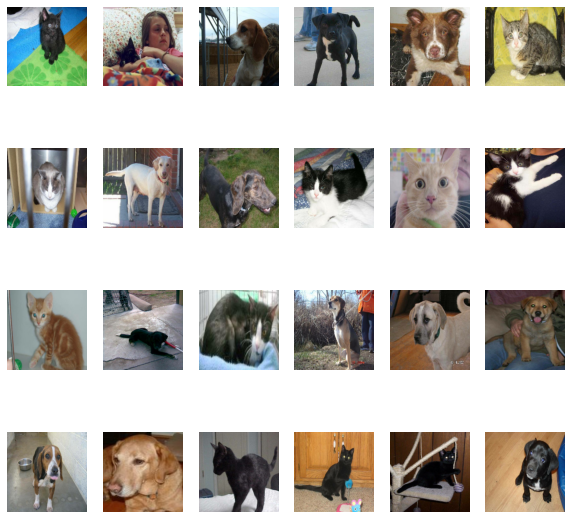

In [10]:
n_row = 4
n_col =6
plt.rcParams['figure.figsize'] = [10*n_row, 10*n_col]
plt.figure(figsize=(10,10)),
for i in range(n_row*n_col):
  for img, _ in cats_v_dogs_train.take(1):
    ax = plt.subplot(n_row,n_col,i+1)
    ax.axis('off')
    plt.imshow(img[0].numpy().astype("uint8"))

# Model 2 - train a dogs vs cats binary classification CNN off a small sample size (2k training images)

*   Use a relatively small dataset; 2000 training images, 1000 validation images and 2000 test images
*   Train  CNN with `Conv2D` and `MaxPooling` layers

In [11]:
inputs = keras.Input(shape=(180,180,3)) ##180*180 RGB images
x = layers.Rescaling(1./255)(inputs)##rescale to 0-1
x = layers.Conv2D(filters=32,kernel_size=3,activation ='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64,kernel_size=3,activation ='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128,kernel_size=3,activation ='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256,kernel_size=3,activation ='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256,kernel_size=3,activation ='relu')(x)
#x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
dog_cat_cnn = keras.Model(inputs=inputs, outputs=outputs)

dog_cat_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [12]:
##compile the model 
dog_cat_cnn.compile(
    loss = 'binary_crossentropy', ##2 outcomes - cat or dog
    optimizer='rmsprop',
    metrics = ['accuracy','FalsePositives']
)

In [13]:
##import validation dataset
cats_v_dogs_val = import_img_dir(
    new_dir /'validation',
    image_size=(180,180),
    batch_size =batch_n
)

Found 1000 files belonging to 2 classes.


### Train the model, using an early stoppimg mechanism

In [ ]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=5e-3, ## ignore any improvement under 0.005
    patience=25, ##keep training for 25 
    epochs
    restore_best_weights=True,
    verbose =1
)

history1 = dog_cat_cnn.fit(
    cats_v_dogs_train,
    epochs= 60, 
    validation_data = cats_v_dogs_val,
    callbacks = [early_stop], 
    verbose =0

)

### We can see dramatic overfitting from epoch 8 onwards (an expected problem with our small sample size...)

Training accuracy reaches around 98%, but validation accuracy pleateaus at approx 70%

In [ ]:
plt.rcParams['figure.figsize'] = [10, 8]
plot_training(history1)

## Our initial cats vs dogs model is 69% accurate... can we do better??

In [ ]:
dogs_vs_cats_test = import_img_dir(
    new_dir /'test',
    image_size=(180,180),
    batch_size =batch_n
)

test_loss, test_acc, test_FP = dog_cat_cnn.evaluate(dogs_vs_cats_test)

print(f"Model Testing Accuracy = {test_acc:.3f}, with {test_FP:.0f} false positives")

# Model 3: Dogs vs Cats CNN with Data Augmentation

Data Augmentation performs random transformations on existing training data to produce new (slightly different) training images. So we can increase the number of training samples, but each training image will still be unique, meaning the model won't see the **EXACT** same image twice.

Should reduce overfitting!!

In [69]:
##define some random layers of augementation

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),  
    ]
)

### Apply the augmentation layers to a sample image to see how the images are modified

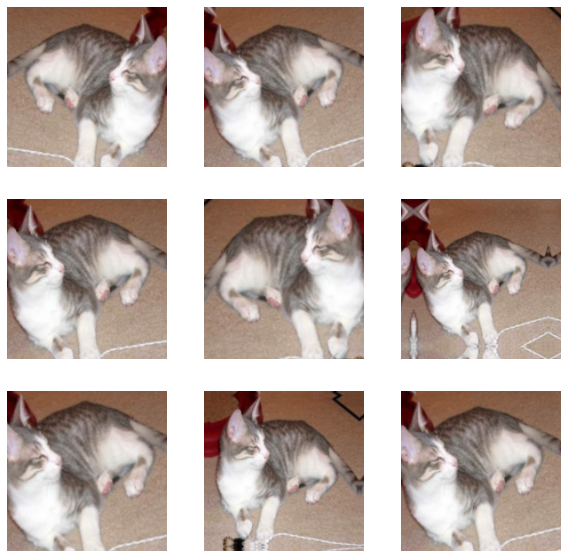

In [70]:
plt.figure(figsize=(10,10))
for img, _ in cats_v_dogs_train.take(1):
  for i in range(9):
    augmented_img = data_augmentation(img)
    ax = plt.subplot(3,3,i+1)
    ax.axis("off")
    plt.imshow(augmented_img[0].numpy().astype("uint8"))
    

### Initiate the augmentation CNN 

Same as before, but apply the `data_augmentation` layers at very start before rescaling. And `Droupout(0.5)` layer added at the end, just before final output layer

In [71]:
inputs = keras.Input(shape=(180,180,3)) ##180*180 RGB images (3 channels)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)##rescale to 0-1
x = layers.Conv2D(filters=32,kernel_size=3,activation ='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64,kernel_size=3,activation ='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128,kernel_size=3,activation ='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256,kernel_size=3,activation ='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256,kernel_size=3,activation ='relu')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
dog_cat_cnn2 = keras.Model(inputs=inputs, outputs=outputs)

dog_cat_cnn2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [72]:
##compile the model 
dog_cat_cnn2.compile(
    loss = 'binary_crossentropy', ##2 outcomes - cat or dog
    optimizer='rmsprop',
    metrics = ['accuracy']
)

### Train the model - this time use `ModelCheckpoint()` to save the model file

In [73]:
model_filepath = 'dogs-vs-cat-CNN-with-augmentation.keras'

save_best_model_file = keras.callbacks.ModelCheckpoint(
    filepath=model_filepath,
    save_best_only = True,
    montior = 'val_loss'
)


history2 = dog_cat_cnn2.fit(
    cats_v_dogs_train,
    epochs= 110, 
    validation_data = cats_v_dogs_val,
    callbacks = [save_best_model_file],
    verbose=0

)

### Plot the training results

We still see overfitting (as expected), but we have delayed the point of overfitting around ~10-12 epochs by adding the augmentation. 

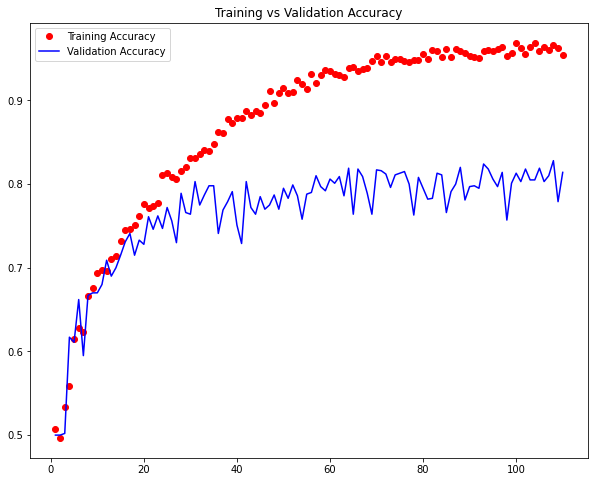

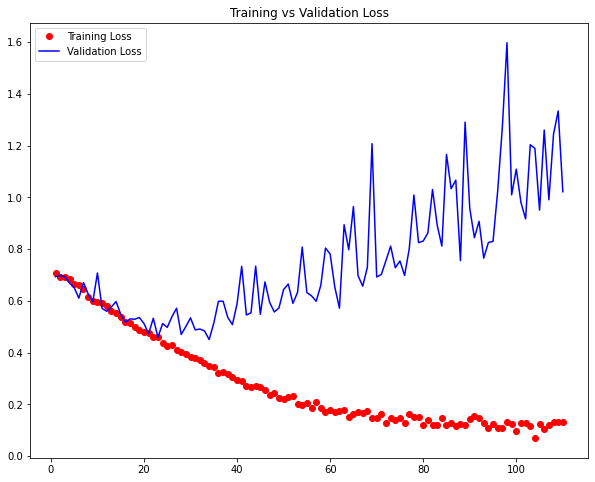

In [74]:

plot_training(history2)




### We achieve around ~79% accuracy on the test set



*  Approx 10% increase due to augmentation
*  Can also see that we delay that point at which overfitting occurs to around epoch 22 (was around epoch 10 without augmentation)


In [75]:
test_model = keras.models.load_model(model_filepath)

test_loss, test_acc = test_model.evaluate(dogs_vs_cats_test, verbose=0)

print(f"Data Augmentation CNN Testing Accuracy = {test_acc*100:.1f}%")

Data Augmentation CNN Testing Accuracy = 78.4%
